In [21]:
import os
import sys

import pandas as pd
import numpy as np

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import transforms, utils
from torchvision.utils import save_image, make_grid
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Данные и модель

In [22]:
from dataset import ArchDataset, GS_NEGATIVE_PATHS, GS_POSITIVE_PATHS, GS_NEGATIVE_COORDS, GS_POSITIVE_COORDS

In [23]:
from model import VQVAE

# Параметры модели и обучения

In [24]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [38]:
results_dir = 'v1_064pix_gray_64embeds'
os.mkdir(results_dir)

In [39]:
params = {
    'batch_size': 64,
    'img_size': 64,
    'channels': 1,
    'embedding_dim': 64,
    'num_embeddings': 64,
    'beta': 0.25,
    'n_epochs': 10,
}

# Датасет

In [40]:
transform_crop_64_grayscale = transforms.Compose([
    transforms.CenterCrop((64, 64)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

In [41]:
train_dataset = ArchDataset(
    img_paths=GS_NEGATIVE_PATHS, 
    coords=GS_NEGATIVE_COORDS, 
    anomalies=False, 
    transform=transform_crop_64_grayscale
)
train_loader = DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True)

anomalies_dataset = ArchDataset(
    img_paths=GS_POSITIVE_PATHS, 
    coords=GS_POSITIVE_COORDS, 
    anomalies=True, 
    transform=transform_crop_64_grayscale
)
anomalies_loader = DataLoader(anomalies_dataset, batch_size=params['batch_size'], shuffle=False)

In [42]:
print(f'train: {len(train_dataset)} images, {len(train_loader)} batches')
print(f'anomalies: {len(anomalies_dataset)} images, {len(anomalies_loader)} batches')

train: 99254 images, 1551 batches
anomalies: 165 images, 3 batches


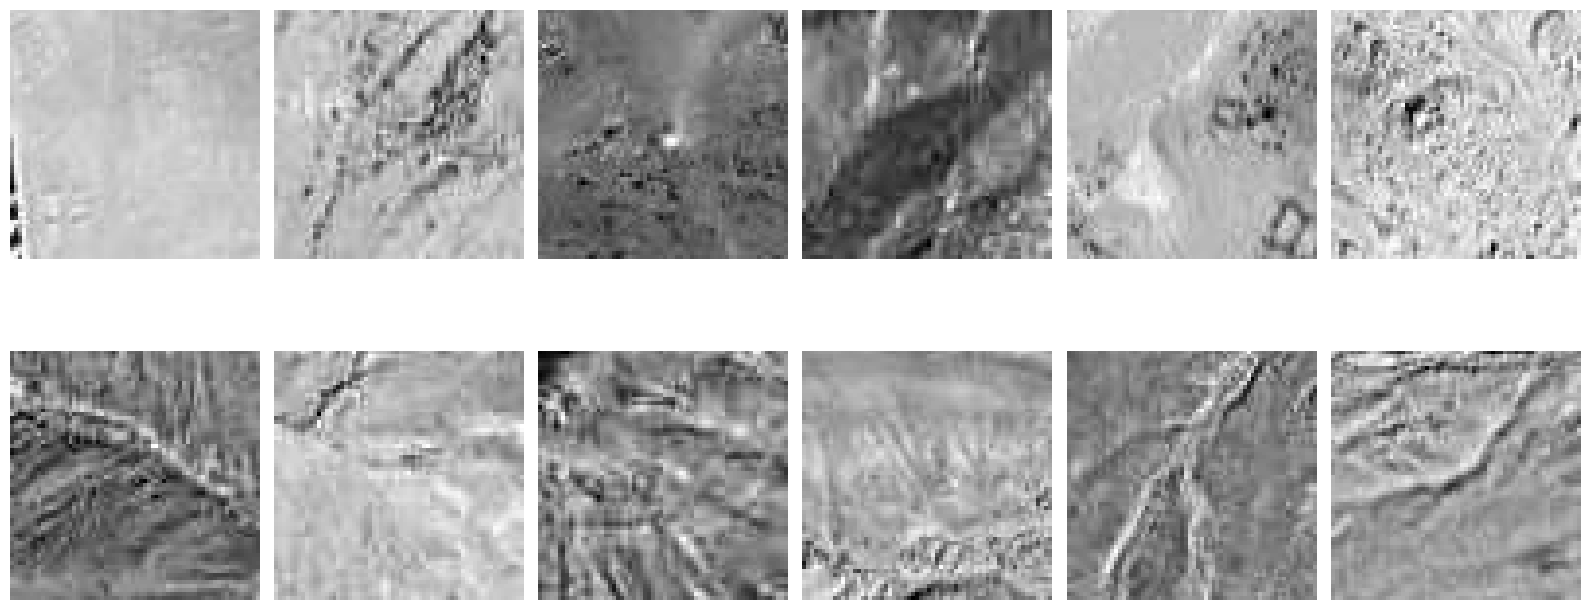

In [43]:
ncols = 6

fig, axs = plt.subplots(nrows=2, ncols=ncols, figsize=(16, 8))
for i in range(ncols):
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[0, i].imshow(anomalies_dataset[i][0].permute(1, 2, 0), cmap='gray')
    axs[1, i].imshow(train_dataset[i][0].permute(1, 2, 0), cmap='gray')
fig.tight_layout()
fig.show()

# Создание модели

In [44]:
model = VQVAE(
    in_channels=params['channels'],
    img_size=params['img_size'],
    
    embedding_dim=params['embedding_dim'],
    num_embeddings=params['num_embeddings'],
    beta=params['beta']
)

In [45]:
# model

In [46]:
total_params = sum(param.numel() for param in model.parameters())
total_params

9675841

# Цикл обучения

In [47]:
def train_vqvae(pbar, model, dataloader, optimizer, scheduler, n_epochs, device):
    
    model = model.to(device)
    model.train()

    for epoch in range(n_epochs):
        
        running_loss = 0.0
        current_lr = optimizer.param_groups[0]['lr']
        
        for batch_idx, (data, _, _, _) in enumerate(dataloader):

            data = data.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            reconstructions, original_input, vq_loss = outputs
            
            loss_dict = model.loss_function(reconstructions, original_input, vq_loss)
            total_loss = loss_dict['loss']
            total_loss.backward()
            optimizer.step()
            running_loss += total_loss.item()
            curr_loss = running_loss / (1 + batch_idx)
            
            pbar.set_description(
                f'Epoch [{epoch + 1}/{n_epochs}] [Batch {batch_idx + 1}/{len(dataloader)}] [Loss {curr_loss:.4f}] [LR {current_lr:.6f}]'
            )
            pbar.update(1)
            
            if batch_idx % 100 == 0:        
                with torch.no_grad():
                    log_imgs = torch.cat([original_input[: 8], reconstructions[: 8]])
                    utils.save_image(
                        log_imgs.cpu().data,
                        f'{results_dir}/sample_{epoch}_{batch_idx}.png',
                        normalize=True,
                        nrow=8
                    )

        avg_loss = running_loss / len(dataloader)
        scheduler.step(avg_loss)
                
        torch.save(model.state_dict(), f'{results_dir}/checkpoint_{epoch}.pth')
        torch.save(optimizer.state_dict(), f'{results_dir}/optimizer_{epoch}.opt')


In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, min_lr=1e-6)

In [ ]:
with tqdm(
    total=params['n_epochs'] * len(train_loader), 
    desc=f'[Epoch ?] [Batch ?] [Loss ?] [LR ?]'
) as pbar:
    train_vqvae(pbar, model, train_loader, optimizer, scheduler, params['n_epochs'], device)

Epoch [6/10] [Batch 1245/1551] [Loss 0.0086] [LR 0.001000]:  58%|█████▊    | 9000/15510 [26:55<19:18,  5.62it/s]